# 3.1. Classification with Logistic Regression

### Import libraries and load the dataset

In [64]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count

In [65]:
spark = SparkSession.builder.appName("Structured_API").getOrCreate()

In [66]:
data = spark.read.csv("../../data/creditcard.csv", header=True, inferSchema=True)

### 3.1.1. Structured API Implementation (High-Level)


**a. Preprocess your data appropriately (e.g., handle missing values and standardize features if necessary).**

- First, we will observer the data and check for missing values.

In [67]:
print(f"Number of rows: {data.count()}")

Number of rows: 284807


In [68]:
data.show()

+----+------------------+-------------------+------------------+-------------------+-------------------+-------------------+--------------------+-------------------+------------------+-------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+------+-----+
|Time|                V1|                 V2|                V3|                 V4|                 V5|                 V6|                  V7|                 V8|                V9|                V10|               V11|               V12|                V13|                V14|                V15|                V16|                 V17|                V18|                V19|                V20|                 V

In [69]:
data.printSchema()


root
 |-- Time: double (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable = true)
 |-- V28: double (nulla

In [70]:
data.describe().toPandas()

,summary,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,count,284807,284807,284807,284807,284807,284807,284807,284807,284807,...,284807,284807,284807,284807,284807,284807,284807,284807,284807,284807
1,mean,94813.85957508067,2.3120013345304016E-15,3.001769688478698E-16,1.647779956654264E-15,1.5839125164738662E-15,-8.430502103812514E-16,1.5807191444648464E-15,-5.843870776506401E-16,-1.528826849318273E-16,...,2.770250217824756E-16,-8.318734083496817E-16,2.4908301670355153E-16,4.465631375988472E-15,3.4488417697414826E-16,1.6140499648089914E-15,-3.779156186924478E-16,-1.247410941023395E-16,88.34961925094233,0.001727485630620034
2,stddev,47488.14595456595,1.9586958038574855,1.6513085794769953,1.5162550051777728,1.4158685749409223,1.380246734031438,1.332271089757576,1.2370935981826678,1.1943529026692048,...,0.734524014371313,0.7257015604409108,0.6244602955949896,0.6056470678271609,0.5212780705409429,0.48222701326105755,0.40363249496503156,0.33008326416025063,250.12010924018833,0.04152718963546499
3,min,0.0,-56.407509631329,-72.7157275629303,-48.3255893623954,-5.68317119816995,-113.743306711146,-26.1605059358433,-43.5572415712451,-73.2167184552674,...,-34.8303821448146,-10.933143697655,-44.8077352037913,-2.83662691870341,-10.2953970749851,-2.60455055280817,-22.5656793207827,-15.4300839055349,0.0,0
4,max,172792.0,2.45492999121121,22.0577289904909,9.38255843282114,16.8753440335975,34.8016658766686,73.3016255459646,120.589493945238,20.0072083651213,...,27.2028391573154,10.5030900899454,22.5284116897749,4.58454913689817,7.51958867870916,3.5173456116238,31.6121981061363,33.8478078188831,25691.16,1


In [71]:
null_counts = data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns])
null_counts.show()

+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|Time| V1| V2| V3| V4| V5| V6| V7| V8| V9|V10|V11|V12|V13|V14|V15|V16|V17|V18|V19|V20|V21|V22|V23|V24|V25|V26|V27|V28|Amount|Class|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|   0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|     0|    0|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+



In [72]:
data = data.dropna()

- We can see that there are **no missing values** in the dataset.

- Next, we check for duplicates.

In [73]:
duplicate_count = data.groupBy(data.columns).count().filter(col("count") > 1).count()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 773


In [74]:
data = data.dropDuplicates()
print(f"Number of rows: {data.count()}, Number of columns: {len(data.columns)}")

Number of rows: 283726, Number of columns: 31


- Next, we combine numeric features into a single vector column. Acording to the documentation, we can see that **Time** is not a feature that we need to use for our model. We will drop it.

In [75]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

# Drop the 'Time' column and any duplicates
numeric_data = data.drop("Time")
numeric_data = numeric_data.dropDuplicates()

# Assemble feature columns into a single vector column
feature_columns = numeric_data.columns[:-1]  # Assuming the last column is the label
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data_with_features = assembler.transform(numeric_data).select("features", "Class")

# Standardize the features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scaler_model = scaler.fit(data_with_features)
data_preprocessed = scaler_model.transform(data_with_features)

data_preprocessed.show()

+--------------------+-----+--------------------+
|            features|Class|      scaledFeatures|
+--------------------+-----+--------------------+
|[-0.2478269732790...|    0|[-0.1269265864426...|
|[-0.5861247433321...|    0|[-0.3001885223242...|
|[1.32666628811126...|    0|[0.67946285697045...|
|[-1.5369580132194...|    0|[-0.7871654628327...|
|[-1.1616645455556...|    0|[-0.5949558815489...|
|[1.25941843981117...|    0|[0.64502132819976...|
|[-0.5891532884219...|    0|[-0.3017396161582...|
|[-2.3622283143894...|    0|[-1.2098343145484...|
|[-0.4701629085458...|    0|[-0.2407977318372...|
|[-0.3616248748527...|    0|[-0.1852091010534...|
|[-1.5128701462661...|    0|[-0.7748286671780...|
|[-0.4102796803822...|    0|[-0.2101280527647...|
|[-0.7856777802210...|    0|[-0.4023912222622...|
|[0.55872023853782...|    0|[0.28615308380572...|
|[1.2262969534004,...|    0|[0.62805789136154...|
|[-5.9484815178005...|    0|[-3.0465628643318...|
|[-1.3246594196772...|    0|[-0.6784350230894...|


Training Accuracy: 0.9991889405932968
Training Recall: 0.5013054830287206
Training F1-Score: 0.6368159203980099
Training Precision: 0.8727272727272727
Training Coefficients: [0.11862780167633881,0.10001405531155301,0.038403737991474424,1.0365611561604477,0.2043239993270267,-0.14547576625698494,-0.08193921647230068,-0.20532789181898115,-0.23896471898951793,-0.9403286258998127,-0.01575083726150094,0.07748527913588324,-0.35138006652338577,-0.4928970037278771,-0.1205861451407969,-0.19661884076075187,-0.01866552194562804,-0.019636907051681817,0.018190933005698493,-0.386084783046706,0.2590157508960783,0.4334885209770166,-0.031160130830991593,0.08342256072912159,-0.0011630662673897064,-0.025576892811289446,-0.31892487710634243,-0.09271440060263918,0.2745582442010376]
Training Intercept: -8.806317906611596


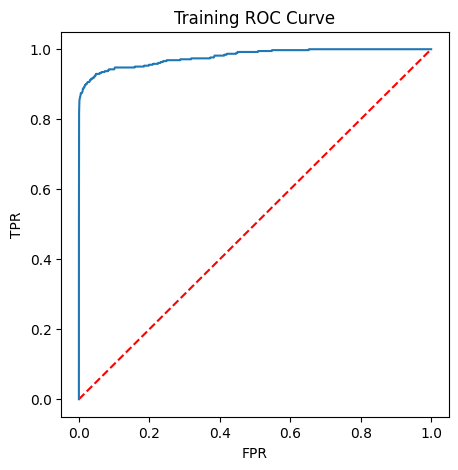

Testing AUC: 0.9704644579703806
Testing Accuracy: 0.999144894840259
Testing Precision: 0.9990672527855351
Testing Recall: 0.999144894840259
Testing F1-Score: 0.9990695495448116


In [76]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt

# Split the data into training and testing sets
train_data, test_data = data_preprocessed.randomSplit([0.8, 0.2], seed=42)

# Initialize the Logistic Regression model
lr = LogisticRegression(featuresCol="scaledFeatures", labelCol="Class", predictionCol="prediction")

# Fit the model on the training data
lr_model = lr.fit(train_data)

# Inspect metrics of trainning data
training_summary = lr_model.summary
print(f"Training Accuracy: {training_summary.accuracy}")
print(f"Training Recall: {training_summary.recallByThreshold.collect()[0]['recall']}")
print(f"Training F1-Score: {training_summary.fMeasureByThreshold.collect()[0]['F-Measure']}")
print(f"Training Precision: {training_summary.precisionByThreshold.collect()[0]['precision']}")
print(f"Training Coefficients: {lr_model.coefficients}")
print(f"Training Intercept: {lr_model.intercept}")
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(lr_model.summary.roc.select('FPR').collect(),
         lr_model.summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Training ROC Curve')
plt.show()


# Make predictions on the test data
predictions = lr_model.transform(test_data)

# Evaluate metrics of testing data
evaluator = BinaryClassificationEvaluator(labelCol="Class", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
test_auc = evaluator.evaluate(predictions)

print(f"Testing AUC: {test_auc}")

# Accuracy, precision, recall from MulticlassClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="accuracy")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="weightedRecall")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="f1")

print(f"Testing Accuracy: {evaluator_accuracy.evaluate(predictions)}")
print(f"Testing Precision: {evaluator_precision.evaluate(predictions)}")
print(f"Testing Recall: {evaluator_recall.evaluate(predictions)}")
print(f"Testing F1-Score: {evaluator_f1.evaluate(predictions)}")


In [77]:
print(f"Training precision: {training_summary.precisionByThreshold.precision}")

Training precision: Column<'precision'>


In [78]:
# df_pandas = data.toPandas()

In [79]:
# df_pandas['Class'].value_counts(sort=False).plot.bar(
#     title="Class Distribution",
#     rot=0,
# );

In [80]:
spark.stop()